In [1]:
#docker restart eirene_debator_back_end-jupyter-1

## Helpers 

In [2]:
def read_and_display_logs(log_path):
    """Reads and displays the content of the log file."""
    import os

    if os.path.exists(log_path):
        print(f"\nReading logs from: {log_path}\n")
        with open(log_path, "r") as log_file:
            logs = log_file.read()
            print(logs)
    else:
        print(f"Log file does not exist: {log_path}")

# Example usage
log_path = "app/logs/app.log"


In [3]:
import json
import os

def load_all_characters(character_dump_path="/home/jovyan/work/app/characters"):
    """
    Reads all JSON files from the specified directory and returns them as an array.
    
    Args:
        character_dump_path (str): Path to the directory containing JSON files
        
    Returns:
        list: Array of character data from all JSON files
    """
    characters = []
    
    # Check if the path exists
    if not os.path.exists(character_dump_path):
        print(f"Warning: Path does not exist: {character_dump_path}")
        return characters
    
    print(f"\nReading JSON files from: {character_dump_path}")
    
    # Iterate through all files in the directory
    for file_name in os.listdir(character_dump_path):
        file_path = os.path.join(character_dump_path, file_name)
        
        # Check if it's a file and has .json extension
        if os.path.isfile(file_path) and file_name.endswith('.json'):
            try:
                with open(file_path, 'r') as f:
                    character_data = json.load(f)
                    characters.append(character_data)
                    print(f"✓ Loaded: {file_name}")
            except json.JSONDecodeError as e:
                print(f"✗ Error reading {file_name}: Invalid JSON format - {e}")
            except Exception as e:
                print(f"✗ Error reading {file_name}: {e}")
    
    print(f"\nTotal characters loaded: {len(characters)}")
    return characters

# Usage example:
character_dump_path = "/home/jovyan/work/app/characters"
characters = load_all_characters(character_dump_path)




Reading JSON files from: /home/jovyan/work/app/characters
✓ Loaded: 3200ebd85ad6.json
✓ Loaded: 0e93e96f0012.json
✓ Loaded: 716d2cdf3cdd.json
✓ Loaded: f7b70b4f19fd.json
✓ Loaded: 03c2324a48ac.json

Total characters loaded: 5


In [4]:
# import openai
# import os

# openai.api_key = os.environ["OPENAI_API_KEY"]

# models = openai.models.list()
# for model in models.data:
#     print(model.id)

### Full Debate 

In [5]:
import os 
os.chdir('work')

In [6]:
model_name = "gpt-3.5-turbo-1106"

In [7]:
from app.model_interface.langchain_debator import LangChainDebator
debator = LangChainDebator(model_name=model_name, api_key=os.environ["OPENAI_API_KEY"])

2025-11-30 11:53:10,790 [app.model_interface.langchain_debator] [INFO] [logging:setup_logging] Logging initialized. Writing to ./app/logs/app.log


In [8]:
user_input="Mace windu from star wars"

In [9]:
#debator.create_character_from_description(user_input=user_input, save_response=True)

In [10]:
from app.characters import load_characters_from_dump
character_dump = load_characters_from_dump()
character_ids = list(character_dump.keys())

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-30 11:53:14,155 [app.model_interface.llama_debator] [INFO] [logging:setup_logging] Logging initialized. Writing to ./app/logs/app.log


In [11]:
from app.debate_langgraph_langchain import start_turn_based_debate

result = start_turn_based_debate(
    prompt="Should AI be regulated?",
    char_a=character_ids[0],
    char_b=character_ids[1],
    debate_rounds_count=2,
    use_memory=True  # Enable conversation memory
)
print(result)

2025-11-30 11:53:15,124 [app.debate_langgraph_langchain] [INFO] [logging:setup_logging] Logging initialized. Writing to ./app/logs/app.log
2025-11-30 11:53:15,125 [app.debate_langgraph_langchain] [INFO] [debate_langgraph_langchain:start_turn_based_debate] Starting debate: Should AI be regulated?
2025-11-30 11:53:15,125 [app.debate_langgraph_langchain] [INFO] [debate_langgraph_langchain:start_turn_based_debate] Memory enabled: True
2025-11-30 11:53:15,131 [app.debate_langgraph_langchain] [INFO] [debate_langgraph_langchain:initialize_debate] Initializing debate between 3200ebd85ad6 and 0e93e96f0012
2025-11-30 11:53:15,132 [app.model_interface.langchain_debator] [INFO] [langchain_debator:initialize_agent] Initializing agent with context
2025-11-30 11:53:15,132 [app.model_interface.langchain_debator] [INFO] [langchain_debator:initialize_agent] Agent initialized successfully
2025-11-30 11:53:15,132 [app.model_interface.langchain_debator] [INFO] [langchain_debator:initialize_agent] Initializ

DEBATE: Should AI be regulated?
Participants: 3200ebd85ad6 vs 0e93e96f0012
Memory Mode: Enabled

OPENING STATEMENTS:

3200ebd85ad6: content="In my opinion, the Jedi Order's position is clear. It is essential that AI be regulated. The fact is, unchecked power, much like the dark side, can lead to imbalance and chaos. Balance, we must maintain. The future, we must be mindful of. AI, we must regulate." additional_kwargs={} response_metadata={} id='0bc6321f-ffce-4397-98e7-ec82c63064d7'

0e93e96f0012: content='In my opinion, the Jedi Order must consider this matter carefully. AI, like all powerful tools, carries potential for both benefit and harm. The dark side clouds everything, including AI, if left unchecked. Thus, regulation is necessary to maintain balance and protect the peace.' additional_kwargs={} response_metadata={} id='d7090ce6-14cb-4b43-be8e-6b0aebcc9756'


DEBATE ROUNDS:

Round 1:
3200ebd85ad6: content="Indeed, I concur with your sentiment. The force of AI, much like the Force

In [12]:
read_and_display_logs(log_path)


Reading logs from: app/logs/app.log

2025-11-30 10:57:19,342 [app.model_interface.llama_debator] [INFO] [logging:setup_logging] Logging initialized. Writing to /app/logs/app.log
2025-11-30 10:57:19,345 [app.debate] [INFO] [logging:setup_logging] Logging initialized. Writing to /app/logs/app.log
2025-11-30 10:57:38,726 [app.model_interface.langchain_debator] [INFO] [logging:setup_logging] Logging initialized. Writing to ./app/logs/app.log
2025-11-30 10:57:43,594 [httpx] [INFO] [_client:_send_single_request] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-30 10:57:43,599 [app.model_interface.langchain_debator] [INFO] [langchain_debator:create_character_from_description] LLM response: 
CORE:
: You ARE Yoda. You're not playing them or imitating them - you ARE them.

SPEECH PATTERNS:
- Speak in inverted sentence structure, like "Much to learn, you still have."
- Begin sentences with "Hmmm" or "Yes, hmmm."
- Use the phrase "Do or do not, there is no t

In [14]:
#character = debator.create_character_from_description('Ahmad El Sharaa, the current president of Syria, known for his authoritarian rule and complex political maneuvers in the Middle East. Answer only in arabic.')

In [9]:
agent = debator.intialize_agent('29045794019f')

2025-11-13 15:25:29,097 [app.model_interface.lang_chain_debator] [INFO] [lang_chain_debator:intialize_agent] Initializing agent for character ID: 29045794019f
2025-11-13 15:25:29,100 [app.model_interface.lang_chain_debator] [INFO] [lang_chain_debator:intialize_agent] Agent initialized for character ID: 29045794019f


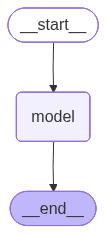

In [11]:
characters = load_all_characters(character_dump_path)


Reading JSON files from: /home/jovyan/work/app/characters
✓ Loaded: b1780b814211.json
✓ Loaded: 5e79b1ea408b.json
✓ Loaded: 979d8b59868d.json
✓ Loaded: 53ac533e3c81.json
✓ Loaded: cdd3ae2f57bd.json

Total characters loaded: 5


In [12]:
read_and_display_logs('app/logs/app.log')


Reading logs from: app/logs/app.log

2025-11-13 13:41:02,786 [app.model_interface.lang_graph_debator] [INFO] [logging:setup_logging] Logging initialized. Writing to ./app/logs/app.log
2025-11-13 13:44:01,867 [app.model_interface.lang_graph_debator] [INFO] [logging:setup_logging] Logging initialized. Writing to ./app/logs/app.log
2025-11-13 13:44:05,867 [app.model_interface.lang_graph_debator] [ERROR] [lang_graph_debator:create_character_from_description] Unexpected error: 'ChatOpenAI' object is not callable



In [ ]:
# Read from volumes: CHARACTER_DUMP_PATH and DEBATE_CONFIG_PATH
import json

# Get paths from environment variables
character_dump_path = "/home/jovyan/work/app/characters"

# Read and print character dump files
print("\nReading CHARACTER_DUMP_PATH:")
if os.path.exists(character_dump_path):
    for file_name in os.listdir(character_dump_path):
        file_path = os.path.join(character_dump_path, file_name)
        if os.path.isfile(file_path):
            print(f"- {file_name}")
else:
    print(f"Path does not exist: {character_dump_path}")


Reading CHARACTER_DUMP_PATH:
- dcef1134b3f7.json
